In [18]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [19]:
# Set up parameters
data_dir = "dataset"
classes = ['clean', 'dirty']
image_size = 224

# Load and preprocess images
images = []
labels = []
for class_idx, class_name in enumerate(classes):
    class_path = os.path.join(data_dir, class_name)
    for file in os.listdir(class_path):
        try:
            img_path = os.path.join(class_path, file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (image_size, image_size))
            images.append(img)
            labels.append(class_idx)
        except:
            continue

images = np.array(images) / 255.0
labels = np.array(labels)

print("Total Images:", len(images))
print("Class Distribution:", Counter(labels))

Total Images: 2444
Class Distribution: Counter({0: 1412, 1: 1032})


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=42
)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)

In [21]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Add classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=12
)

Epoch 1/12
62/62 [==============================] - 52s 792ms/step - loss: 0.4278 - accuracy: 0.8102 - val_loss: 3.5096 - val_accuracy: 0.7751
Epoch 2/12
62/62 [==============================] - 37s 595ms/step - loss: 0.3219 - accuracy: 0.8675 - val_loss: 4.7094 - val_accuracy: 0.7239
Epoch 3/12
62/62 [==============================] - 35s 559ms/step - loss: 0.2722 - accuracy: 0.8834 - val_loss: 2.6018 - val_accuracy: 0.7669
Epoch 4/12
62/62 [==============================] - 34s 554ms/step - loss: 0.2210 - accuracy: 0.9136 - val_loss: 4.5462 - val_accuracy: 0.7157
Epoch 5/12
62/62 [==============================] - 34s 554ms/step - loss: 0.1885 - accuracy: 0.9223 - val_loss: 3.1692 - val_accuracy: 0.7648
Epoch 6/12
62/62 [==============================] - 34s 555ms/step - loss: 0.1882 - accuracy: 0.9248 - val_loss: 6.4391 - val_accuracy: 0.6380
Epoch 7/12
62/62 [==============================] - 35s 557ms/step - loss: 0.1510 - accuracy: 0.9478 - val_loss: 2.4210 - val_accuracy: 0.8221

16/16 [==============================] - 6s 356ms/step
              precision    recall  f1-score   support

       clean       0.83      0.92      0.87       283
       dirty       0.87      0.75      0.80       206

    accuracy                           0.85       489
   macro avg       0.85      0.83      0.84       489
weighted avg       0.85      0.85      0.84       489



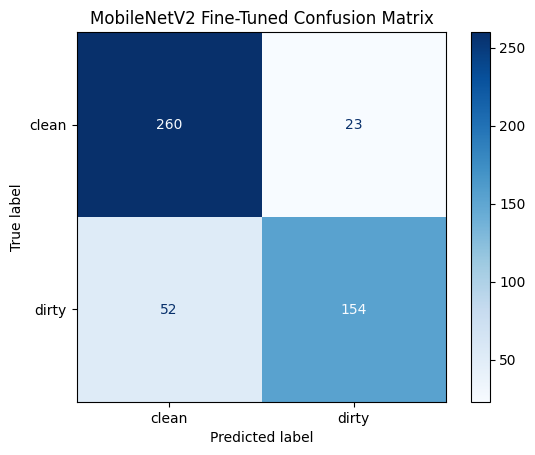

In [22]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names=classes))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred.ravel(), display_labels=classes, cmap='Blues')
plt.title("MobileNetV2 Fine-Tuned Confusion Matrix")
plt.show()

In [ ]:
model.save("mobilenetv2_classifier.h5")
print("✅ Model saved as .h5")